# Лабораторная 1

Лабораторная состоит из набора примеров и одного задания:

## **Задание - 1** - подбор двух изображений;

Сначала нужно ознакомиться с примерами, после чего выполнять задания.

## Работа с изображениями

Загрузим изображение с помощью библиотеки `imageio`:

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg

In [35]:
kitten = mpimg.imread("kitten.jpg", )

Изображения представляются массивами numpy с размерностью `(высота, ширина, число каналов)`, где каналы - как правило компоненты RGB.

Убедимся в этом, взглянув на размерность загруженного изображения:

In [36]:
print(kitten.shape)

(150, 150, 3)


Для вывода изображения воспользуемся matplotlib:

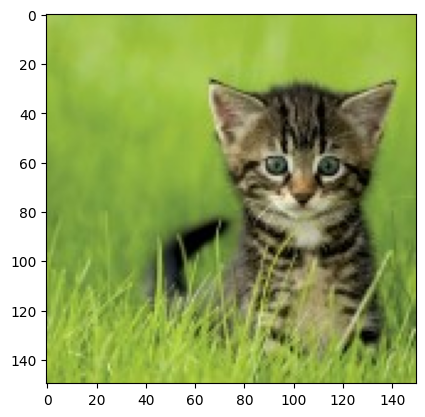

In [37]:
plt.imshow(kitten)
plt.show()

### Размерности изображений

Часто возникает проблема, когда изображение хранится в "сыром" виде с неправильным порядком каналов, например вместо `(высота, ширина, число каналов)`  `(число каналов, высота, ширина)`.

Такая же проблема часто появляется при обработке изображений с помощью библиотек глубокого обучения: в Theano каналы идут до высоты, в Tensorflow - после ширины. Соответственно, может возникнуть задача переводить одно представление в другое.

Рассмотрим пример: дан numpy массив `data`, содержащий изображение, в котором каналы располагаются по горизонтали.
Вот как выглядят каналы цвета по отдельности:

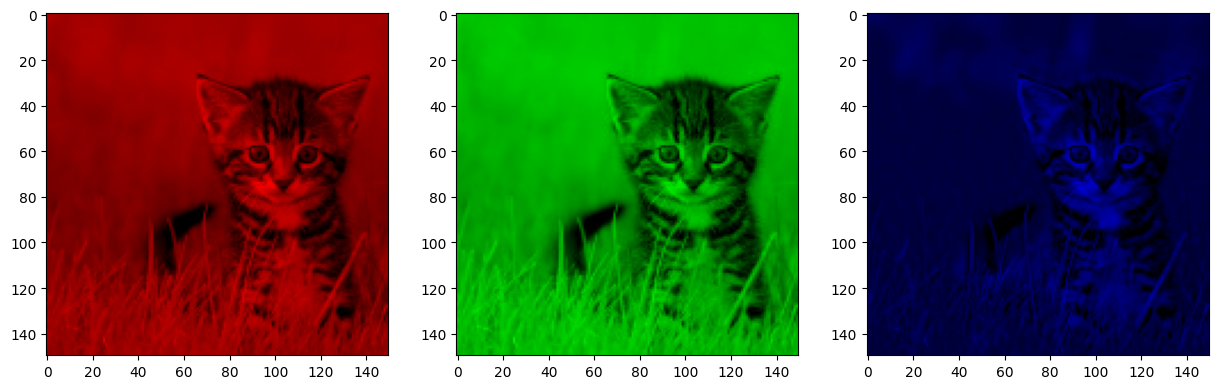

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

for cnt, ax in zip(range(3), ax):
    split_img = np.zeros(kitten.shape, dtype="uint8")  # 'dtype' по умолчанию: 'numpy.float64'
    split_img[:, :, cnt] = kitten[:, :, cnt]
    ax.imshow(split_img)

А вот что будет, если мы выведем изображение, в котором каналы цвета располагаются в порядке `BGR`, а не `RGB`

Размерность: (150, 150, 3)


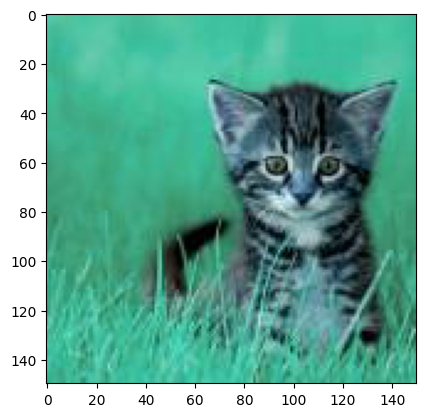

In [39]:
data = np.load("kitten_wrong_shape.npy")
print("Размерность:", data.shape)
plt.imshow(data)
plt.show()

In [40]:
result = data.reshape((150, 3, 150))  # разрежем изображение на три квадрата по горизонтали
result = np.dstack([result[:, i, :] for i in range(3)])  # составим из трёх изображений (150, 150) одно (150, 150, 3)

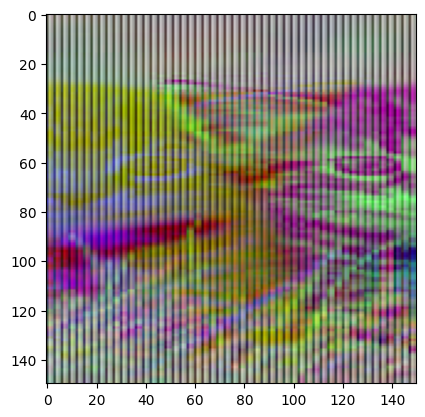

In [41]:
plt.imshow(result)
plt.show()

Поскольку задача типичная, существует более традиционный метод переставить оси `(150, 3, 150) -> (150, 150, 3)`: `np.swapaxes(result, -1, 1)`

### Пример задачи поиска описывающего прямоугольника

Рассмотрим простую задачу. Пусть дано изображение тёмного котёнка на фоне зелёной травы. Требуется найти описывающий прямоугольник (такой, чтобы весь котёнок оказался внутри).

Посмотрим на значения каналов:

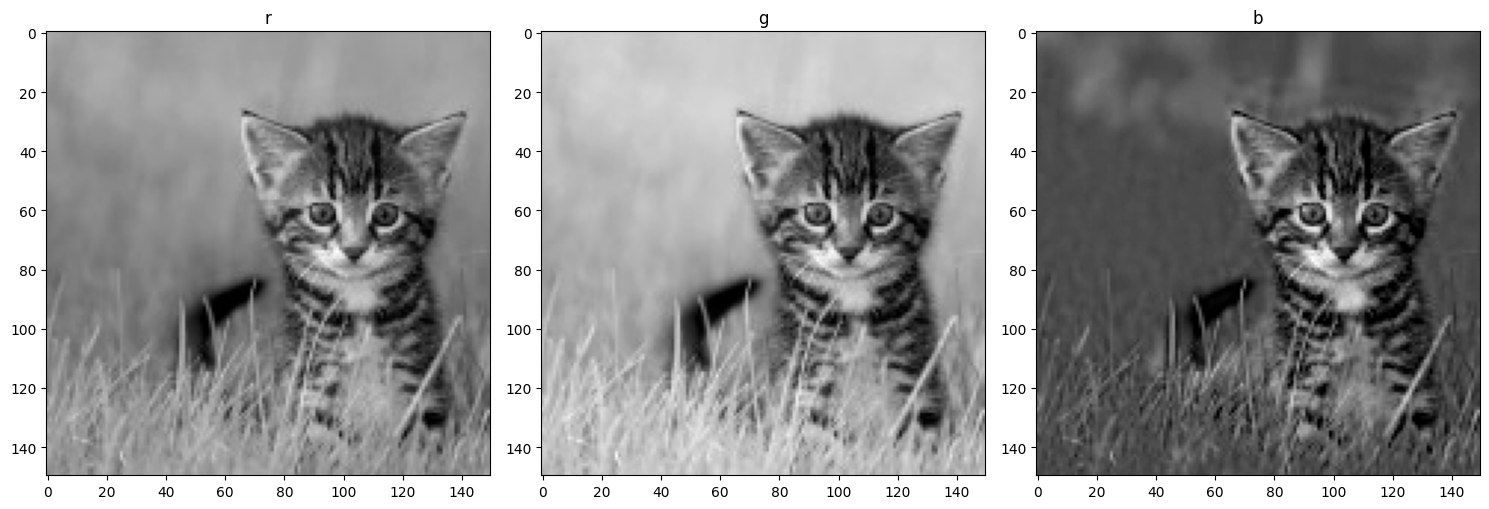

In [42]:
f, ax = plt.subplots(1, 3, figsize=(15, 5))  # создадим сетку, в которую будем выводить картинки
f.set_dpi(100)  # повысим чёткость изображений
for i in range(3):
    ax[i].set_title("rgb"[i])  # поставим подпись, соответствующую номеру канала
    ax[i].imshow(kitten[..., i], cmap="gray")  # выведем значение канала с чёрно-белой цветовой схемой
f.tight_layout()  # добавим границы, чтобы графики не наезжали друг на друга

Заметим, что синий канал самый тусклый, а зелёный ярче красного почти только на траве.

Значит для пикселей вокруг котёнка выполнено: $g > r$. Тогда пикселям котёнка соответствует обратное неравенство.

Проверим это:

Результат - матрица типа bool


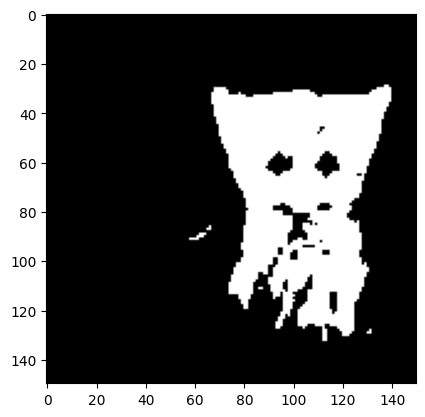

In [43]:
r = kitten[..., 0]  # Берём все значения по высоте и ширине, фиксируя только номер канала. Равносильно kitten[:, :, 0]
g = kitten[..., 1]
b = kitten[..., 2]
mask = r > g
plt.imshow(mask, cmap="gray")
print(f"Результат - матрица типа {mask.dtype}")

Переберём все строки, чтобы найти верхнюю и нижнюю границы описывающего прямоугольника:

In [44]:
top = mask.shape[0]
bottom = 0
for row in range(mask.shape[0]):  # проходим по всем строкам # shape[0] вернет количество строк
    if mask[row, :].sum() > 0:  # проверяем, что в строке есть хоть один элемент равный true
        top = min(top, row)
        bottom = max(bottom, row)
print(f"Top: {top}, bottom: {bottom}")

Top: 29, bottom: 132


Аналогично поступим со столбцами:

In [45]:
left = mask.shape[1]
right = 0
for col in range(mask.shape[1]):  # проходим по всем столбцам
    if mask[:, col].sum() > 0:
        left = min(left, col)
        right = max(right, col)
print(f"Left: {left}, right: {right}")

Left: 58, right: 139


Нарисуем описывающий прямоугольник поверх изображения с помощью `matplotlib.patches`:

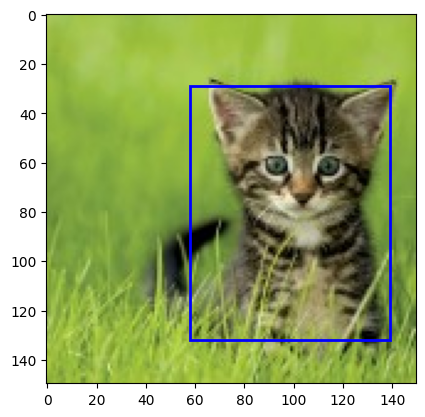

In [46]:
from matplotlib.patches import Rectangle

f, ax = plt.subplots(1, 1)
ax.imshow(kitten)

corner = (left, top)
height = bottom - top
width = right - left
ax.add_patch(Rectangle(corner, width, height, linewidth=2, edgecolor='b', facecolor='none'))

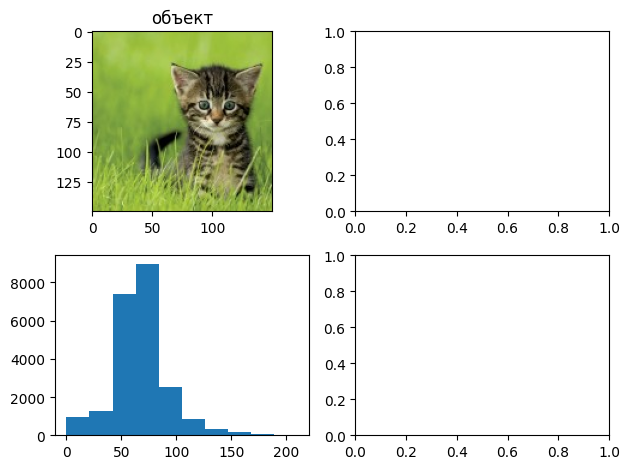

In [47]:
f, ax = plt.subplots(2, 2)  # создадим сетку, в которую будем выводить картинки
f.set_dpi(100)  # повысим чёткость изображений

#airplane_object     = kitten[left:right, top:bottom]
airplane_object = kitten[0:150, 0:150]
#airplane_background = airplane[150:350, 650:850]

ax[0, 0].set_title("объект")
#ax[0, 1].set_title("фон")
ax[0, 0].imshow(airplane_object, cmap="gray")
#ax[0, 1].imshow(airplane_background, cmap="gray")
ax[1, 0].hist(airplane_object[..., 2].flatten())  # выведем гистограмму синего канала куска изображения с объектом
#ax[1, 1].hist(airplane_background[..., 2].flatten())

f.tight_layout()  # добавим границы, чтобы графики не наезжали друг на друга

### Задание 1.

Дано изображение:

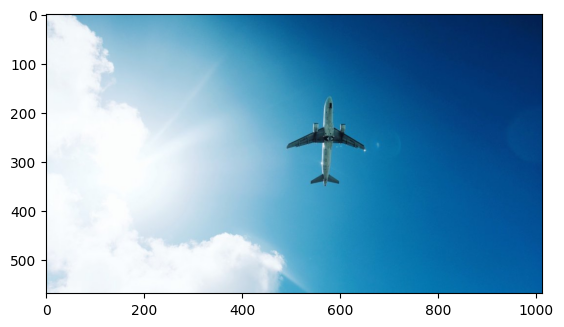

In [49]:
# from skimage import data, io, filters
from skimage.color import rgb2gray

airplane = mpimg.imread("airplane.jpg")
plt.imshow(airplane)

Посмотрим гистограммы интенсивностей пикселей внутри двух прямоугольников: с объектом и без него.

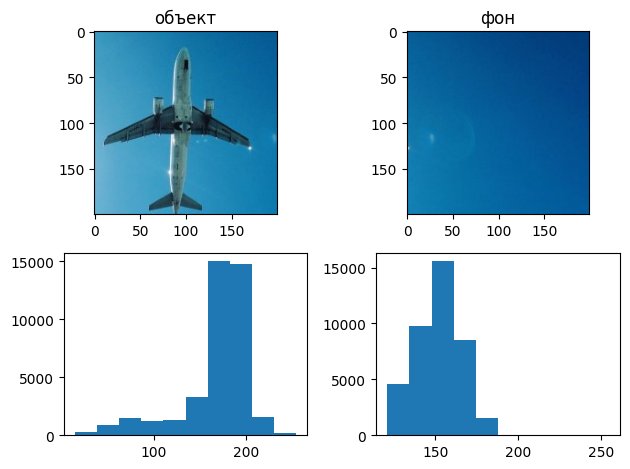

In [50]:
f, ax = plt.subplots(2, 2)  # создадим сетку, в которую будем выводить картинки
f.set_dpi(100)  # повысим чёткость изображений

airplane_object = airplane[150:350, 480:680]
airplane_background = airplane[150:350, 650:850]

ax[0, 0].set_title("объект")
ax[0, 1].set_title("фон")
ax[0, 0].imshow(airplane_object, cmap="gray")
ax[0, 1].imshow(airplane_background, cmap="gray")
ax[1, 0].hist(airplane_object[..., 2].flatten())  # выведем гистограмму синего канала куска изображения с объектом
ax[1, 1].hist(airplane_background[..., 2].flatten())

f.tight_layout()  # добавим границы, чтобы графики не наезжали друг на друга

*В коде `flatten` склеивает все размерности в одну. В данном случае `(150, 150) -> (22500,)`*

**Задача: подобрать два изображения, на которых объект:**
* имеет гистограмму, аналогичную гистограмме фона;
* имеет гистограмму, сильно отличающуюся от фона.

*Изображения надо поместить в папку с блокнотом.*

Гистограммы близки:

In [52]:
first_img = mpimg.imread("<your_image>")
f, ax = plt.subplots(2, 2)
f.set_dpi(100)

first_object = first_img[150:350, 480:680]
first_background = first_img[150:350, 650:850]

ax[0, 0].set_title("объект")
ax[0, 1].set_title("фон")
ax[0, 0].imshow(first_object, cmap="gray")
ax[0, 1].imshow(first_background, cmap="gray")
ax[1, 0].hist(rgb2gray(first_object).flatten())
ax[1, 1].hist(rgb2gray(first_background).flatten())

f.tight_layout()

OSError: [Errno 22] Invalid argument: '<your_image>'

Гистограммы различны:

In [53]:
second_img = mpimg.imread("<your_image>")
f, ax = plt.subplots(2, 2)
f.set_dpi(100)

second_object = second_img[150:350, 480:680]
second_background = second_img[150:350, 650:850]

ax[0, 0].set_title("объект")
ax[0, 1].set_title("фон")
ax[0, 0].imshow(second_object, cmap="gray")
ax[0, 1].imshow(second_background, cmap="gray")
ax[1, 0].hist(rgb2gray(second_object).flatten())
ax[1, 1].hist(rgb2gray(second_background).flatten())

f.tight_layout()

OSError: [Errno 22] Invalid argument: '<your_image>'